In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jsphyg/tipping")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\benkc\.cache\kagglehub\datasets\jsphyg\tipping\versions\1


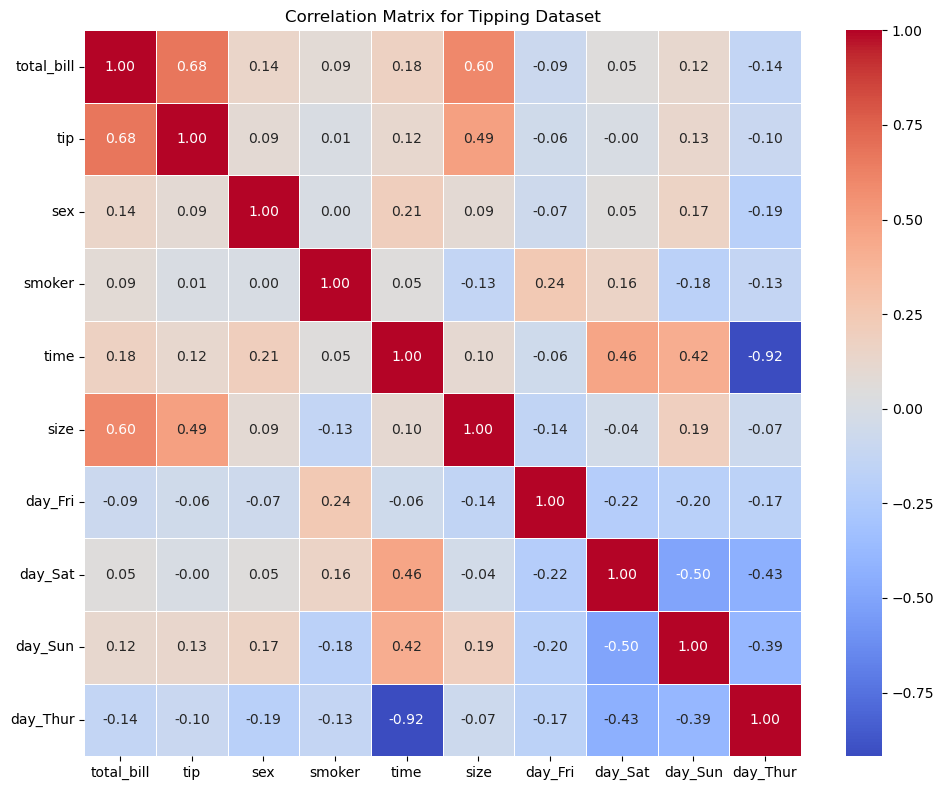

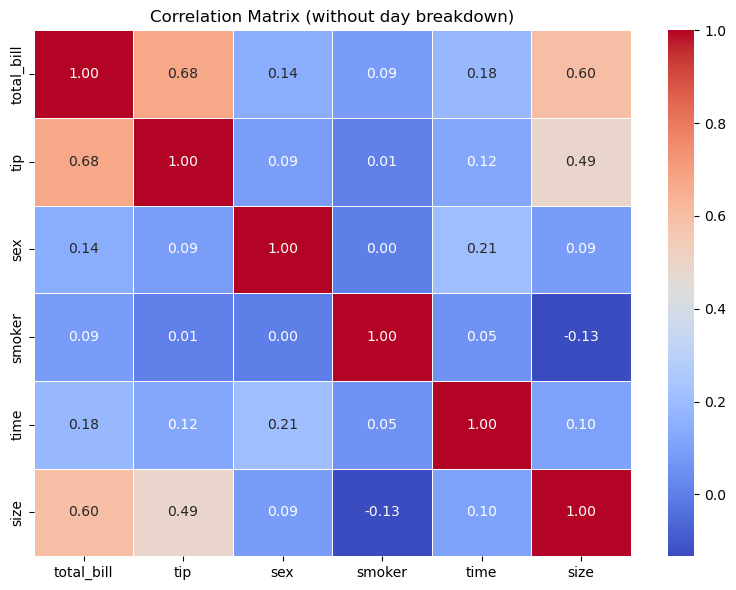

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv('C:/Users/benkc/.cache/kagglehub/datasets/jsphyg/tipping/versions/1/tips.csv')

df_encoded = df.copy()
df_encoded['sex'] = df_encoded['sex'].map({'Female': 0, 'Male': 1})
df_encoded['smoker'] = df_encoded['smoker'].map({'No': 0, 'Yes': 1})
df_encoded['time'] = df_encoded['time'].map({'Lunch': 0, 'Dinner': 1})

# Use one-hot encoding for days since they're not binary
day_dummies = pd.get_dummies(df_encoded['day'], prefix='day')
df_encoded = pd.concat([df_encoded.drop('day', axis=1), day_dummies], axis=1)

# Now create a correlation matrix for the specified columns plus day dummies
corr_matrix = df_encoded[['total_bill', 'tip', 'sex', 'smoker', 'time', 'size'] + list(day_dummies.columns)].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix for Tipping Dataset')
plt.tight_layout()
plt.show()

# If you want just the original variables mentioned, without the day dummies
corr_subset = df_encoded[['total_bill', 'tip', 'sex', 'smoker', 'time', 'size']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_subset, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix (without day breakdown)')
plt.tight_layout()
plt.show()


Linear Regression Results:
Mean Squared Error: 0.6656
R² Score: 0.4675
Cross-Validation R² Score: 0.4430 (±0.1252)

Linear Regression Coefficients:
      Feature  Coefficient
0  total_bill     0.092336
1        time    -0.045394
2        size     0.253057
3     day_Sat    -0.147072
4     day_Sun     0.027246
5    day_Thur    -0.060533

Random Forest Results:
Mean Squared Error: 0.8535
R² Score: 0.3172
Cross-Validation R² Score: 0.2862 (±0.1414)

Random Forest Feature Importances:
      Feature  Importance
0  total_bill    0.825884
2        size    0.081714
3     day_Sat    0.038873
4     day_Sun    0.029117
1        time    0.013661
5    day_Thur    0.010752


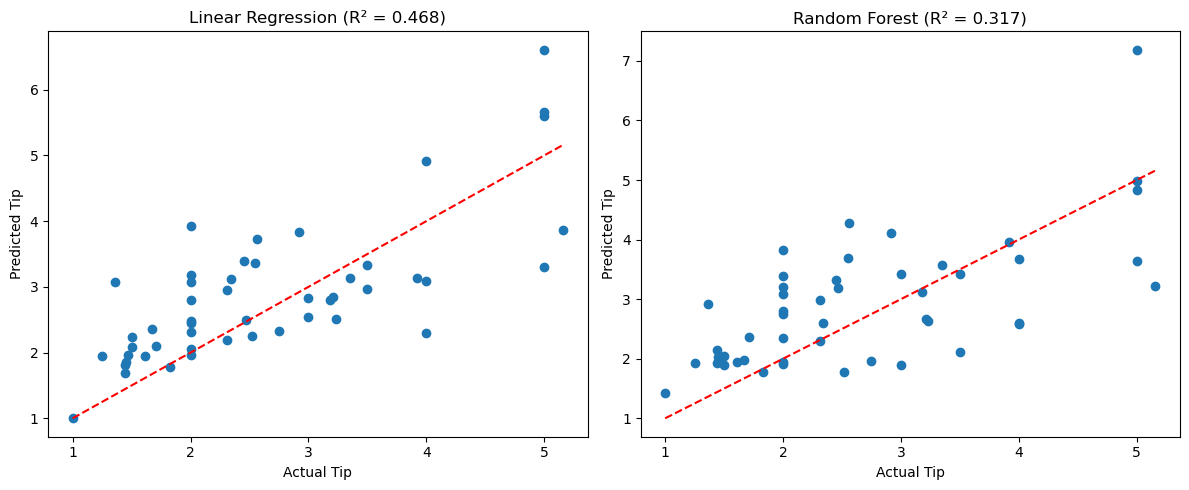


Best model: Linear Regression with R² = 0.4675
Model exported as tipping_model.json

Sample calculation for React implementation:
prediction = 0.6614
  + (0.0923 * total_bill)
  + (-0.0454 * time)
  + (0.2531 * size)
  + (-0.1471 * day_Sat)
  + (0.0272 * day_Sun)
  + (-0.0605 * day_Thur)


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder

# Load the dataset
df = pd.read_csv('C:/Users/benkc/.cache/kagglehub/datasets/jsphyg/tipping/versions/1/tips.csv')

# Process categorical variables (excluding 'smoker' and 'sex')
df_model = df.copy()

# Convert 'time' to numeric
df_model['time'] = df_model['time'].map({'Lunch': 0, 'Dinner': 1})

# One-hot encode 'day'
encoder = OneHotEncoder(sparse_output=False, drop='first')
day_encoded = encoder.fit_transform(df_model[['day']])
day_df = pd.DataFrame(day_encoded, columns=[f'day_{cat}' for cat in encoder.categories_[0][1:]])
df_model = pd.concat([df_model, day_df], axis=1)

# Select features (excluding 'smoker' and 'sex')
features = ['total_bill', 'time', 'size'] + [col for col in df_model.columns if col.startswith('day_')]
X = df_model[features]
y = df_model['tip']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train multiple models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    
    # Store results
    results[name] = {
        'model': model,
        'mse': mse,
        'r2': r2,
        'cv_r2_mean': cv_scores.mean(),
        'cv_r2_std': cv_scores.std()
    }
    
    print(f"\n{name} Results:")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Cross-Validation R² Score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    
    if name == 'Linear Regression':
        # Print coefficients for linear regression
        coef_df = pd.DataFrame({
            'Feature': features,
            'Coefficient': model.coef_
        })
        print("\nLinear Regression Coefficients:")
        print(coef_df)
        
    elif name == 'Random Forest':
        # Print feature importances for random forest
        imp_df = pd.DataFrame({
            'Feature': features,
            'Importance': model.feature_importances_
        }).sort_values('Importance', ascending=False)
        print("\nRandom Forest Feature Importances:")
        print(imp_df)

# Visualize actual vs predicted values
plt.figure(figsize=(12, 5))

for i, (name, result) in enumerate(results.items()):
    plt.subplot(1, 2, i+1)
    plt.scatter(y_test, result['model'].predict(X_test))
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel('Actual Tip')
    plt.ylabel('Predicted Tip')
    plt.title(f'{name} (R² = {result["r2"]:.3f})')

plt.tight_layout()
plt.show()

# Export the best model
best_model_name = max(results, key=lambda x: results[x]['r2'])
best_model = results[best_model_name]['model']

print(f"\nBest model: {best_model_name} with R² = {results[best_model_name]['r2']:.4f}")

# Create a simplified model export for use in React
if best_model_name == 'Linear Regression':
    model_data = {
        'intercept': float(best_model.intercept_),
        'coefficients': best_model.coef_.tolist(),
        'feature_names': features
    }
    
    # Export as JSON
    import json
    with open('tipping_model.json', 'w') as f:
        json.dump(model_data, f)
    
    print("Model exported as tipping_model.json")
    
    # Show a sample prediction calculation
    print("\nSample calculation for React implementation:")
    print(f"prediction = {model_data['intercept']:.4f}")
    for i, feature in enumerate(features):
        print(f"  + ({model_data['coefficients'][i]:.4f} * {feature})")

In [5]:
import json

# Assuming you've already trained your model and it's in the 'results' dictionary
# This code should be added after your model training

# Get the Linear Regression model
linear_model = results['Linear Regression']['model']

# Extract the intercept and coefficients
model_data = {
    'intercept': float(linear_model.intercept_),
    'coefficients': {
        'total_bill': float(linear_model.coef_[0]),
        'time': float(linear_model.coef_[1]),
        'size': float(linear_model.coef_[2])
    }
}

# Add day coefficients
day_features = [f for f in features if f.startswith('day_')]
for i, day_feature in enumerate(day_features):
    model_data['coefficients'][day_feature] = float(linear_model.coef_[3 + i])

# Print in a format easy to copy-paste
print("\nModel data for JavaScript implementation:")
print(f"intercept: {model_data['intercept']:.6f},")
print("coefficients: {")
for feature, coef in model_data['coefficients'].items():
    print(f"  {feature}: {coef:.6f},")
print("}")

# Save to a JSON file
with open('tip_model_coefficients.json', 'w') as f:
    json.dump(model_data, f, indent=2)

print("\nCoefficients saved to 'tip_model_coefficients.json'")


Model data for JavaScript implementation:
intercept: 0.661437,
coefficients: {
  total_bill: 0.092336,
  time: -0.045394,
  size: 0.253057,
  day_Sat: -0.147072,
  day_Sun: 0.027246,
  day_Thur: -0.060533,
}

Coefficients saved to 'tip_model_coefficients.json'
